##### source: https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_NeuMF.ipynb

In [1]:
import os
import zipfile
from urllib import request

# data science imports
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def download(url, filename):
    """Download a file if not present"""
    if not os.path.exists(filename):
        print("downloading {}...".format(filename))
        filename, _ = request.urlretrieve(url + filename, filename)

        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory data"""
    data_path = filename.replace('.zip','')
    if not os.path.exists(data_path):
        print("extracting {}...".format(filename))
        with zipfile.ZipFile(filename) as f:
            f.extractall()
            print("extracting {} done".format(filename))

    """directory model for saving model while training"""
    if not os.path.exists('model'):
        os.mkdir('model')
        print("directory model created...")

In [3]:
# download dataset
download(url='https://github.com/kadriansyah/notebook/raw/master/', filename="data.zip")

extracting data.zip...
extracting data.zip done


In [4]:
def load_ratings():
    COL_NAME = ['user_id','movie_id','rating','timestamp']
    df = pd.read_csv('data/movie-ratings.dat', sep='::', header=1, engine='python', names=COL_NAME)
    return df

def load_movies():
    COL_NAME = ['movie_id','movie_name','movie_genre']
    df = pd.read_csv('data/movie-movies.dat', sep='::', header=1, engine='python', names=COL_NAME)
    
    # insert custom index for word embedding training
    df.insert(0, 'mid', range(1, len(df) + 1))
    return df

def load_users():
    COL_NAME = ['user_id','user_fea1','user_fea2','user_fea3','user_fea4']
    df = pd.read_csv('data/movie-users.dat', sep='::', header=1, engine='python', names=COL_NAME)
    
    # insert custom index for word embedding training
    df.insert(0, 'uid', range(1, len(df) + 1))
    return df

In [5]:
users = load_users()
users

,uid,user_id,user_fea1,user_fea2,user_fea3,user_fea4
0,1,3,M,25,15,55117
1,2,4,M,45,7,02460
2,3,5,M,25,20,55455
3,4,6,F,50,9,55117
4,5,7,M,35,1,06810
...,...,...,...,...,...,...
6033,6034,6036,F,25,15,32603
6034,6035,6037,F,45,1,76006
6035,6036,6038,F,56,1,14706
6036,6037,6039,F,45,0,01060


In [6]:
movies = load_movies()
movies

,mid,movie_id,movie_name,movie_genre
0,1,3,Grumpier Old Men (1995),Comedy|Romance
1,2,4,Waiting to Exhale (1995),Comedy|Drama
2,3,5,Father of the Bride Part II (1995),Comedy
3,4,6,Heat (1995),Action|Crime|Thriller
4,5,7,Sabrina (1995),Comedy|Romance
...,...,...,...,...
3876,3877,3948,Meet the Parents (2000),Comedy
3877,3878,3949,Requiem for a Dream (2000),Drama
3878,3879,3950,Tigerland (2000),Drama
3879,3880,3951,Two Family House (2000),Drama


In [7]:
ratings = load_ratings()
ratings

,user_id,movie_id,rating,timestamp
0,1,914,3,978301968
1,1,3408,4,978300275
2,1,2355,5,978824291
3,1,1197,3,978302268
4,1,1287,5,978302039
...,...,...,...,...
1000202,6040,1091,1,956716541
1000203,6040,1094,5,956704887
1000204,6040,562,5,956704746
1000205,6040,1096,4,956715648


In [8]:
# do some preprocessing to make sure data quality
ratings_clean_1 = ratings.merge(movies, on='movie_id', how='left', indicator=True)
ratings_clean_1 = ratings_clean_1[ratings_clean_1._merge != 'left_only']
ratings_clean_1 = ratings_clean_1.astype({'mid': 'int32'})
ratings_clean_1 = ratings_clean_1.drop(['_merge'], axis=1)
ratings_clean_1

,user_id,movie_id,rating,timestamp,mid,movie_name,movie_genre
0,1,914,3,978301968,901,My Fair Lady (1964),Musical|Romance
1,1,3408,4,978300275,3338,Erin Brockovich (2000),Drama
2,1,2355,5,978824291,2285,"Bug's Life, A (1998)",Animation|Children's|Comedy
3,1,1197,3,978302268,1178,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
4,1,1287,5,978302039,1266,Ben-Hur (1959),Action|Adventure|Drama
...,...,...,...,...,...,...,...
1000202,6040,1091,1,956716541,1074,Weekend at Bernie's (1989),Comedy
1000203,6040,1094,5,956704887,1077,"Crying Game, The (1992)",Drama|Romance|War
1000204,6040,562,5,956704746,557,Welcome to the Dollhouse (1995),Comedy|Drama
1000205,6040,1096,4,956715648,1079,Sophie's Choice (1982),Drama


In [9]:
# do some preprocessing to make sure data quality
ratings_clean_2 = ratings_clean_1.merge(users, on='user_id', how='left', indicator=True)
ratings_clean_2 = ratings_clean_2[ratings_clean_2._merge != 'left_only']
ratings_clean_2 = ratings_clean_2.astype({'uid': 'int32'})
ratings_clean_2 = ratings_clean_2[ratings_clean_2.rating != 0]
ratings_clean_2 = ratings_clean_2.drop(['_merge'], axis=1)
ratings_clean_2

,user_id,movie_id,rating,timestamp,mid,movie_name,movie_genre,uid,user_fea1,user_fea2,user_fea3,user_fea4
179,3,3421,4,978298147,3351,Animal House (1978),Comedy,1,M,25.0,15.0,55117
180,3,1641,2,978298430,1594,"Full Monty, The (1997)",Comedy,1,M,25.0,15.0,55117
181,3,648,3,978297867,641,Mission: Impossible (1996),Action|Adventure|Mystery,1,M,25.0,15.0,55117
182,3,1394,4,978298147,1372,Raising Arizona (1987),Comedy,1,M,25.0,15.0,55117
183,3,3534,3,978297068,3464,28 Days (2000),Comedy,1,M,25.0,15.0,55117
...,...,...,...,...,...,...,...,...,...,...,...,...
997424,6040,1091,1,956716541,1074,Weekend at Bernie's (1989),Comedy,6038,M,25.0,6.0,11106
997425,6040,1094,5,956704887,1077,"Crying Game, The (1992)",Drama|Romance|War,6038,M,25.0,6.0,11106
997426,6040,562,5,956704746,557,Welcome to the Dollhouse (1995),Comedy|Drama,6038,M,25.0,6.0,11106
997427,6040,1096,4,956715648,1079,Sophie's Choice (1982),Drama,6038,M,25.0,6.0,11106


In [10]:
num_users = len(ratings_clean_2.uid.unique())
num_items = len(ratings_clean_2.mid.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 6038 unique users and 3704 unique movies in this data set


In [11]:
user_max_id = users.uid.max()
item_max_id = movies.mid.max()
print('There are {} distinct users  in ratings and the max of uid is {}'.format(num_users, user_max_id))
print('There are {} distinct movies in ratings and the max of mid is {}'.format(num_items, item_max_id))
# print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
# print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 6038 distinct users  in ratings and the max of uid is 6038
There are 3704 distinct movies in ratings and the max of mid is 3881


In [12]:
def reduce_item_dim(ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input : pd.DataFrame, ratings should have columns ['uid', 'mid', 'rating']
    output: pd.DataFrame, ratings with new 'mid' that is compressed
    """
    # pivot
    user_item = ratings.pivot(index='uid', columns='mid', values='rating')
    
    # reset mid
    user_item = user_item.T.reset_index(drop=True).T
    
    # undo pivot/melt - compress data frame
    ratings_new = user_item.reset_index('uid').melt(id_vars='uid', value_vars=user_item.columns, var_name='mid', value_name='rating')

    # drop nan and final clean up
    ratings_new = ratings_new.dropna().sort_values(['uid', 'mid']).reset_index(drop=True)
    
#     return ratings_new
    return ratings_new.astype(int)
    """
    note:
    Your sample data may not show it, but the results of your pivot operation possibly contain NaNs,
    which are of float type, so the rest of the column is also upcasted to float automatically by pandas for efficient computation.
    Note that the NaNs are filled by zeros (fill_value=0), so you don't get to see them.
    For example, there is no row with objectid = 32233 and value = 0, so that corresponding entry in your pivot result shows up as NaN,
    which then gets filled with 0.
    Now that it's clear why the columns are upcasted, you can reset the datatype using astype:
    p = p.astype(int)
    """

##### Split Data Into Train/Test

In [13]:
train, test = train_test_split(ratings_clean_2, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(train.shape)
print('shape of test data set:')
print(test.shape)

shape of training data set:
(797800, 12)
shape of test data set:
(199450, 12)


##### Train Generalized Matrix Factorization and Test Model

##### define GMF model architeture and train routine

In [14]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mf_embedding_user = Embedding(
        input_dim = num_users + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'user_embedding',
        embeddings_regularizer = l2(vu_reg),
        input_length = 1
    )
    
    mf_embedding_item = Embedding(
        input_dim = num_items + 1,
        output_dim = latent_dim,
        embeddings_initializer = 'uniform',
        name = 'item_embedding',
        embeddings_regularizer = l2(vi_reg),
        input_length = 1
    ) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mf_embedding_user(user_input))
    item_latent = Flatten()(mf_embedding_item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs, filepath):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner, loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=filepath, monitor='val_rmse', save_best_only=True, save_weights_only=True)
    
    # train model
    history = model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, validation_split=val_split, callbacks=[early_stopper, model_saver])
    
    return history

def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

##### create GMF model

In [15]:
GMF_model = get_GMF_model(user_max_id, item_max_id, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        60390       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        38820       item_input[0][0]                 
______________________________________________________________________________________________

##### train GMF model

In [16]:
# model config
BATCH_SIZE = 2048
EPOCHS = 10000
VAL_SPLIT = 0.25

# train model
history = train_model(
    GMF_model,
    tf.keras.optimizers.Adam(0.01),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-gmf-weights.hdf5')

Train on 598350 samples, validate on 199450 samples
Epoch 1/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 3.6488 - mean_squared_error: 3.6488 - rmse: 1.6240 - val_loss: 0.8803 - val_mean_squared_error: 0.8803 - val_rmse: 0.9382
Epoch 2/10000
598350/598350 [==============================] - 0s 1us/sample - loss: 0.8432 - mean_squared_error: 0.8432 - rmse: 0.9181 - val_loss: 0.8322 - val_mean_squared_error: 0.8322 - val_rmse: 0.9122
Epoch 3/10000
598350/598350 [==============================] - 0s 1us/sample - loss: 0.7944 - mean_squared_error: 0.7944 - rmse: 0.8912 - val_loss: 0.8213 - val_mean_squared_error: 0.8213 - val_rmse: 0.9063
Epoch 4/10000
598350/598350 [==============================] - 0s 1us/sample - loss: 0.7612 - mean_squared_error: 0.7612 - rmse: 0.8725 - val_loss: 0.8113 - val_mean_squared_error: 0.8113 - val_rmse: 0.9007
Epoch 5/10000
598350/598350 [==============================] - 0s 1us/sample - loss: 0.7325 - mean_squared_error: 0.7325

In [17]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

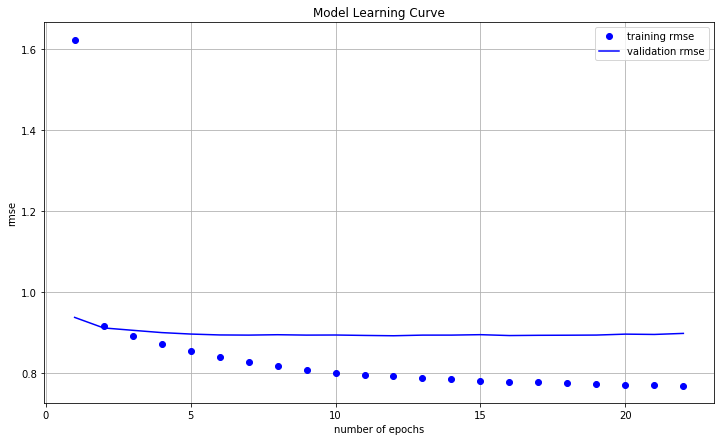

In [18]:
plot_learning_curve(history, 'rmse')

##### GMF model testing

In [19]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(test.rating.values))))

In [20]:
# load best model
GMF_model = get_GMF_model(user_max_id, item_max_id, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, 'model/neural-gmf-weights.hdf5')

# make prediction using test data
predictions = GMF_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8962


#### Train Multi-Layer Perceptron Model and Test Model

##### define MLP model architeture

In [21]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    
    mlp_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(mlp_embedding_user(user_input))
    item_latent = Flatten()(mlp_embedding_item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create MLP model

In [22]:
MLP_model = get_MLP_model(user_max_id, item_max_id, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        193248      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        124224      item_input[0][0]                 
____________________________________________________________________________________________

##### train MLP model

In [23]:
# model config
BATCH_SIZE = 2048
EPOCHS = 10000
VAL_SPLIT = 0.25

# train model
history = train_model(
    MLP_model,
    tf.keras.optimizers.Adam(0.01),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-mlp-weights.hdf5')

Train on 598350 samples, validate on 199450 samples
Epoch 1/10000
598350/598350 [==============================] - 2s 3us/sample - loss: 1.2792 - mean_squared_error: 1.2792 - rmse: 1.0430 - val_loss: 0.8311 - val_mean_squared_error: 0.8311 - val_rmse: 0.9116
Epoch 2/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.8144 - mean_squared_error: 0.8144 - rmse: 0.9024 - val_loss: 0.8083 - val_mean_squared_error: 0.8083 - val_rmse: 0.8990
Epoch 3/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.7815 - mean_squared_error: 0.7815 - rmse: 0.8840 - val_loss: 0.8019 - val_mean_squared_error: 0.8019 - val_rmse: 0.8955
Epoch 4/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.7530 - mean_squared_error: 0.7530 - rmse: 0.8675 - val_loss: 0.7902 - val_mean_squared_error: 0.7902 - val_rmse: 0.8889
Epoch 5/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.7275 - mean_squared_error: 0.7275

##### MLP learning curve

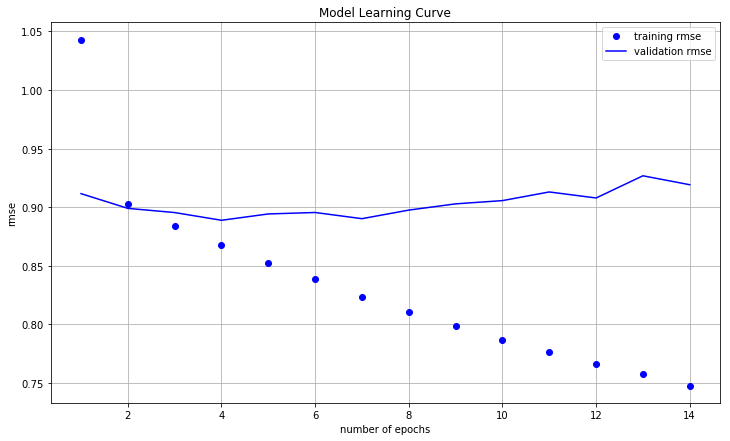

In [24]:
plot_learning_curve(history, 'rmse')

#### MLP model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [25]:
# load best model
MLP_model = get_MLP_model(user_max_id, item_max_id, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, 'model/neural-mlp-weights.hdf5')

# make prediction using test data
predictions = MLP_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8944


#### Train Neural Matrix Factorization (NeuralMF) and Test Model

##### define NeuralMF model architeture

In [26]:
def get_NeuralMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuralMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # MF Embedding layer
    mf_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    
    mf_embedding_item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    mlp_embedding_user = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    
    mlp_embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(mf_embedding_user(user_input))
    mf_item_latent = Flatten()(mf_embedding_item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(mlp_embedding_user(user_input))
    mlp_item_latent = Flatten()(mlp_embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])

    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

##### create NeuralMF model

In [27]:
NeuralMF_model = get_NeuralMF_model(
    num_users=user_max_id,
    num_items=item_max_id,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        193248      user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        124224      item_input[0][0]                 
____________________________________________________________________________________________

##### train NeuralMF model

In [28]:
# model config
BATCH_SIZE = 2048
EPOCHS = 10000
VAL_SPLIT = 0.25

# train model
history = train_model(
    NeuralMF_model,
    tf.keras.optimizers.Adam(0.01),
    BATCH_SIZE,
    EPOCHS,
    VAL_SPLIT,
    inputs=[train.uid.values, train.mid.values],
    outputs=train.rating.values,
    filepath='model/neural-nmf-weights.hdf5')

Train on 598350 samples, validate on 199450 samples
Epoch 1/10000
598350/598350 [==============================] - 2s 3us/sample - loss: 1.2324 - mean_squared_error: 1.2324 - rmse: 1.0331 - val_loss: 0.8101 - val_mean_squared_error: 0.8101 - val_rmse: 0.9000
Epoch 2/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.7581 - mean_squared_error: 0.7581 - rmse: 0.8707 - val_loss: 0.7818 - val_mean_squared_error: 0.7818 - val_rmse: 0.8842
Epoch 3/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.6795 - mean_squared_error: 0.6795 - rmse: 0.8241 - val_loss: 0.7827 - val_mean_squared_error: 0.7827 - val_rmse: 0.8847
Epoch 4/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.6377 - mean_squared_error: 0.6377 - rmse: 0.7983 - val_loss: 0.7949 - val_mean_squared_error: 0.7949 - val_rmse: 0.8915
Epoch 5/10000
598350/598350 [==============================] - 1s 2us/sample - loss: 0.6107 - mean_squared_error: 0.6107

##### Neural Matrix Factorization (NeuralMF) learning curve

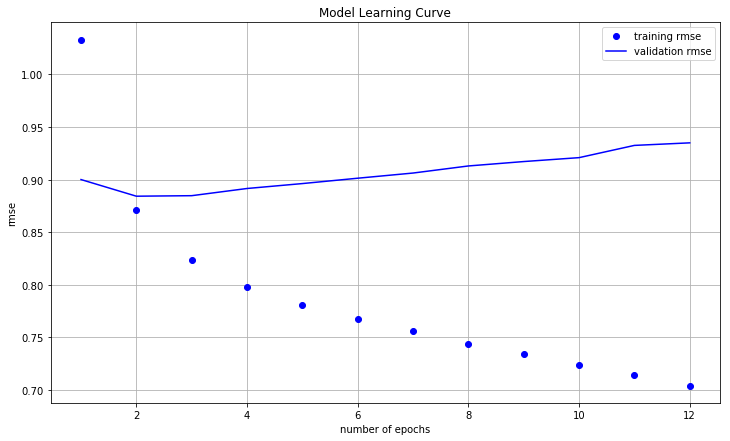

In [29]:
plot_learning_curve(history, 'rmse')

##### Neural Matrix Factorization (NeuralMF) model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [30]:
# load best model
NeuralMF_model = get_NeuralMF_model(
    num_users=user_max_id,
    num_items=item_max_id,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuralMF_model = load_trained_model(NeuralMF_model, 'model/neural-nmf-weights.hdf5')

# make prediction using test data
predictions = NeuralMF_model.predict([test.uid.values, test.mid.values])

# get the RMSE
error = rmse(test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.89


##### Recommendation

In [31]:
# Creating dataset for making recommendations for the user
uid = 1975
movies_data = np.array(list(set(ratings_clean_2.mid)))
users_data = np.array([uid for i in range(len(movies_data))])
ratings_clean_2

,user_id,movie_id,rating,timestamp,mid,movie_name,movie_genre,uid,user_fea1,user_fea2,user_fea3,user_fea4
179,3,3421,4,978298147,3351,Animal House (1978),Comedy,1,M,25.0,15.0,55117
180,3,1641,2,978298430,1594,"Full Monty, The (1997)",Comedy,1,M,25.0,15.0,55117
181,3,648,3,978297867,641,Mission: Impossible (1996),Action|Adventure|Mystery,1,M,25.0,15.0,55117
182,3,1394,4,978298147,1372,Raising Arizona (1987),Comedy,1,M,25.0,15.0,55117
183,3,3534,3,978297068,3464,28 Days (2000),Comedy,1,M,25.0,15.0,55117
...,...,...,...,...,...,...,...,...,...,...,...,...
997424,6040,1091,1,956716541,1074,Weekend at Bernie's (1989),Comedy,6038,M,25.0,6.0,11106
997425,6040,1094,5,956704887,1077,"Crying Game, The (1992)",Drama|Romance|War,6038,M,25.0,6.0,11106
997426,6040,562,5,956704746,557,Welcome to the Dollhouse (1995),Comedy|Drama,6038,M,25.0,6.0,11106
997427,6040,1096,4,956715648,1079,Sophie's Choice (1982),Drama,6038,M,25.0,6.0,11106


In [32]:
# user ratings
ratings_clean_2[ratings_clean_2.uid == uid].sort_values(['rating'], ascending=[0]).head(10)

,user_id,movie_id,rating,timestamp,mid,movie_name,movie_genre,uid,user_fea1,user_fea2,user_fea3,user_fea4
334189,1977,1235,5,974688237,1215,Harold and Maude (1971),Comedy,1975,M,56.0,6.0,02726
334188,1977,1230,5,974683960,1210,Annie Hall (1977),Comedy|Romance,1975,M,56.0,6.0,02726
334182,1977,3725,5,974687096,3655,American Pop (1981),Animation|Musical,1975,M,56.0,6.0,02726
334127,1977,2997,5,974688504,2927,Being John Malkovich (1999),Comedy,1975,M,56.0,6.0,02726
334147,1977,942,5,974687481,929,Laura (1944),Crime|Film-Noir|Mystery,1975,M,56.0,6.0,02726
334153,1977,3429,5,974684834,3359,Creature Comforts (1990),Animation|Comedy,1975,M,56.0,6.0,02726
334124,1977,1252,5,974687332,1231,Chinatown (1974),Film-Noir|Mystery|Thriller,1975,M,56.0,6.0,02726
334157,1977,2857,5,974685487,2787,Yellow Submarine (1968),Animation|Musical,1975,M,56.0,6.0,02726
334140,1977,2238,5,974687934,2168,Seven Beauties (Pasqualino Settebellezze) (1976),Comedy|Drama,1975,M,56.0,6.0,02726
334159,1977,3819,5,974687818,3748,Tampopo (1986),Comedy,1975,M,56.0,6.0,02726


In [33]:
predictions = NeuralMF_model.predict([users_data, movies_data])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:10]

recommendations = ratings_clean_2[ratings_clean_2['mid'].isin(recommended_movie_ids)]
recommendations = recommendations.drop_duplicates(subset='movie_name', keep="last")
recommendations

,user_id,movie_id,rating,timestamp,mid,movie_name,movie_genre,uid,user_fea1,user_fea2,user_fea3,user_fea4
592547,3618,311,3,966600082,307,Relative Fear (1994),Horror|Thriller,3616,M,56.0,17.0,22657
774133,4635,860,4,964036661,848,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",Comedy,4633,M,18.0,4.0,94703
983962,5956,49,3,968378086,47,When Night Is Falling (1995),Drama|Romance,5954,F,18.0,4.0,02142
985402,5964,697,3,957000265,687,Feeling Minnesota (1996),Drama|Romance,5962,M,18.0,5.0,97202
992589,6010,516,3,957463654,511,Renaissance Man (1994),Comedy|Drama|War,6008,M,35.0,0.0,79606
992826,6012,2766,2,956780713,2696,"Adventures of Sebastian Cole, The (1998)",Comedy|Drama,6010,M,35.0,15.0,02871
995203,6029,1566,3,956721594,1525,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical,6027,F,25.0,1.0,23185
996444,6036,3265,4,956710606,3195,Hard-Boiled (Lashou shentan) (1992),Action|Crime,6034,F,25.0,15.0,32603
996594,6036,2377,3,956717123,2307,Lifeforce (1985),Horror|Sci-Fi,6034,F,25.0,15.0,32603
997084,6039,1081,4,956705989,1064,Victor/Victoria (1982),Comedy|Musical,6037,F,45.0,0.0,01060
